## scDEF on simulated and control PBMCs
scDEF is a statistical model that learns signatures of gene expression at multiple levels of resolution in an unsupervised manner. The model enables dimensionality reduction, clustering, and de novo signature identification from scRNA-seq data.

Here we apply scDEF to the two batches of PBMCs sequenced with 10x Genomics, one of which was stimulated with interferon, available from `SeuratData` (https://github.com/satijalab/seurat-data).

### Load packages and data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

import scdef

/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
adata = sc.read_h5ad('pbmcs_data/ifnb/ifnb.h5ad')
obs = pd.read_csv('pbmcs_data/ifnb/ifnb_metadata.csv', index_col=0)
adata.obs = obs

<ipython-input-3-50d85d36ccbb>:9: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('MTRN')  # annotate the group of mitochondrial genes as 'mt'
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/py

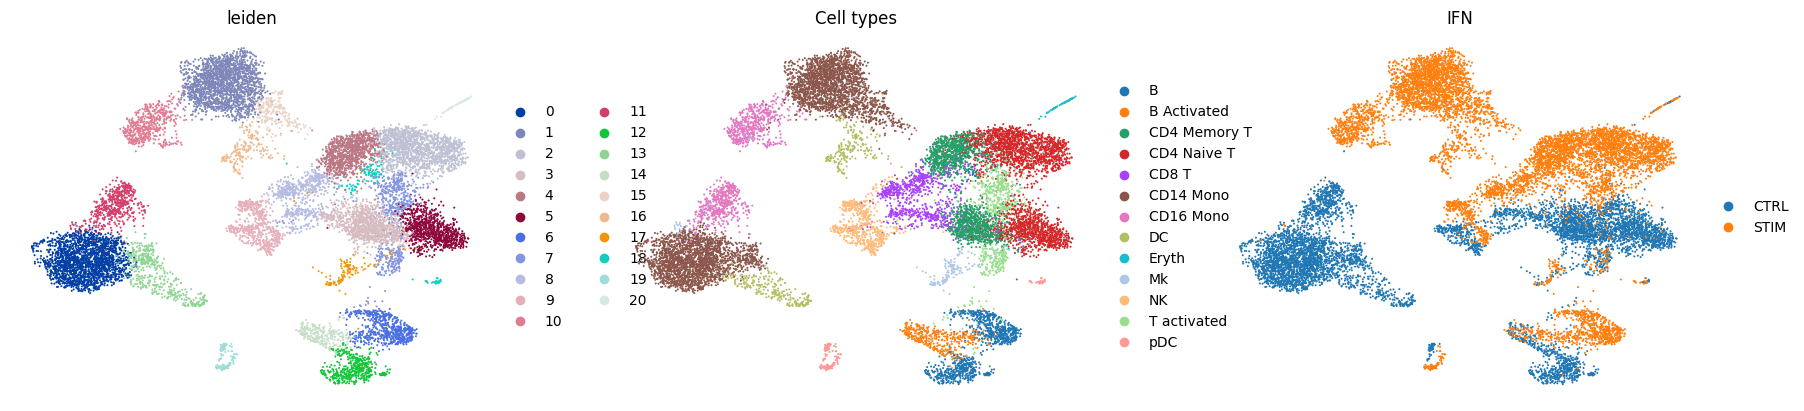

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)

# As in the paper
# Remove MALAT1
adata = adata[:, adata.var_names!='MALAT1']
adata = adata[:, adata.var_names!='FTL']
adata = adata[:, adata.var_names!='FTH1']
adata.var['mt'] = adata.var_names.str.startswith('MTRN')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata.raw = adata


raw_adata = adata.raw
raw_adata = raw_adata.to_adata()
raw_adata.X = raw_adata.X.toarray()
adata.layers['counts'] =  adata.X.toarray()


# Keep only HVGs
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=4000, layer='counts', batch_key='stim') # 

adata = adata[:, adata.var.highly_variable]

# Process and visualize the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
adata.obs['Cell types'] = adata.obs['seurat_annotations']
adata.obs['IFN'] = adata.obs['stim']
sc.pl.umap(adata, color=['leiden', 'Cell types', 'IFN'], ncols=3, frameon=False)

In [4]:
adata

AnnData object with n_obs × n_vars = 13999 × 4000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Cell types', 'IFN'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Cell types_colors', 'IFN_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

### Learn scDEF

We tell scDEF to learn per-batch gene scales by setting `batch_key`. Combined with the sparsity and non-negativity constraints in the model, this provides enough power to correct batch effects and find shared variation between the two experiments. We will see however that this correction does not remove the biological batch-specific effects of interferon stimulation.

In [5]:
scd = scdef.scDEF(adata, counts_layer='counts', batch_key='IFN',)
print(scd) # inspect the scDEF object, which contains a copy of the input AnnData

scDEF object with 5 layers
	Layer names: factor, hfactor, hhfactor, hhhfactor, hhhhfactor
	Layer sizes: 100, 60, 30, 10, 1
	Layer shape parameters: 0.3, 0.3, 0.3, 0.3, 1.0
	Layer rate parameters: 0.3, 3.0, 6.0, 10.0, 30.0
	Layer factor shape parameters: 1.0, 1.0, 1.0, 1.0, 1.0
	Layer factor rate parameters: 100.0, 1.0, 1.0, 1.0, 1.0
	Using BRD with prior parameter: 1000.0
	Number of batches: 2
Contains AnnData object with n_obs × n_vars = 13999 × 4000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Cell types', 'IFN'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Cell types_colors', 'IFN_c

In [6]:
scd.learn(n_epoch=1000) # learn the hierarchical gene signatures

100%|██████████| 1000/1000 [24:25<00:00,  1.47s/it, Loss=1.12e+7]


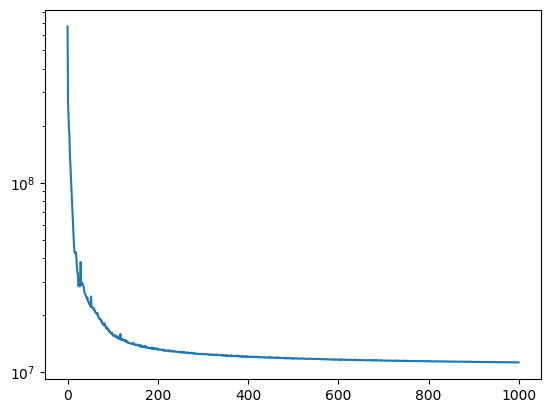

In [7]:
plt.plot(np.concatenate(scd.elbos))
plt.yscale('log')
plt.show()

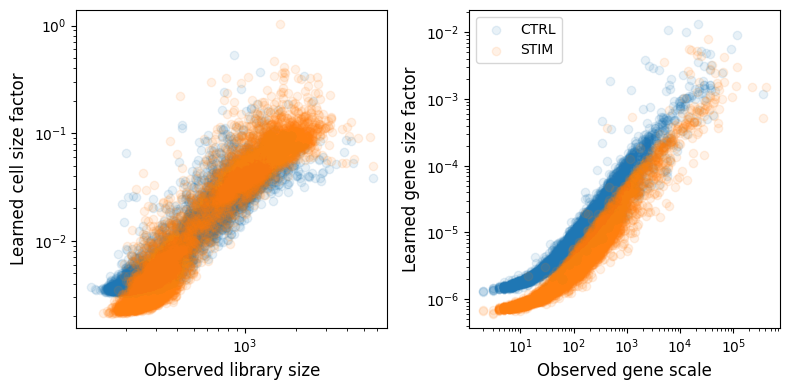

In [8]:
scd.plot_scales(alpha=0.1)

### Downstream analyses

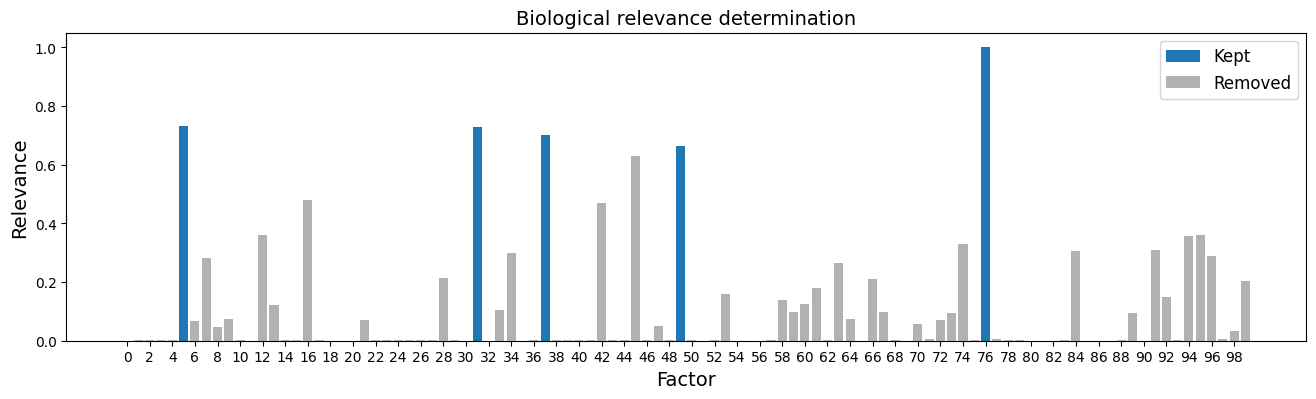

In [9]:
# See relevances
scd.plot_brd(figsize=(16,4))

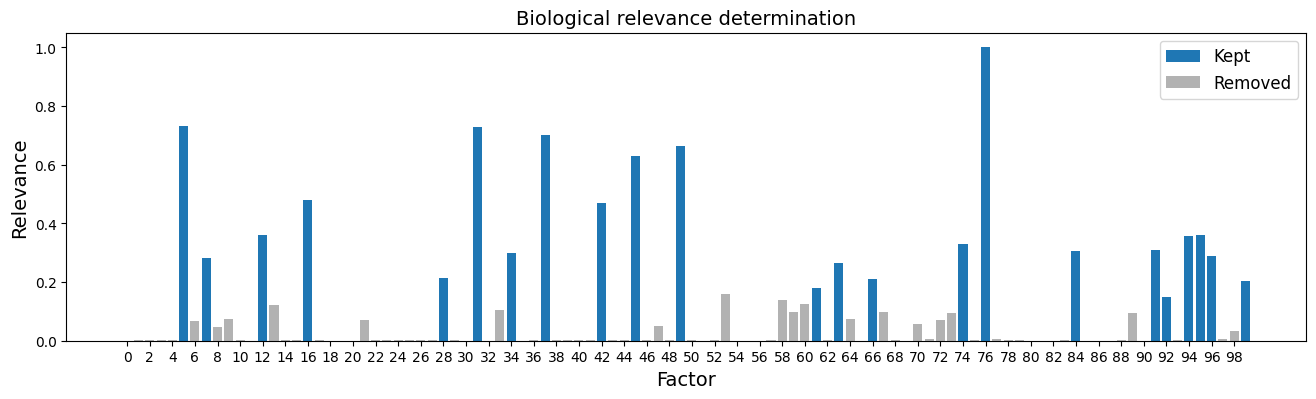

In [10]:
# Actually do the filtering
scd.filter_factors(iqr_mult=1., min_cells=10)
scd.plot_brd(figsize=(16,4))

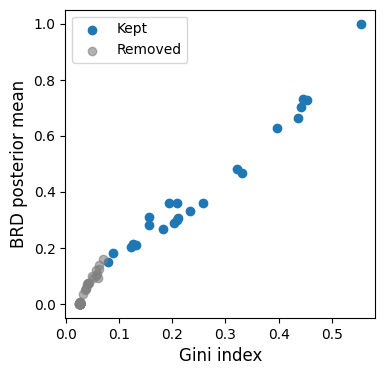

In [11]:
scd.plot_gini_brd()

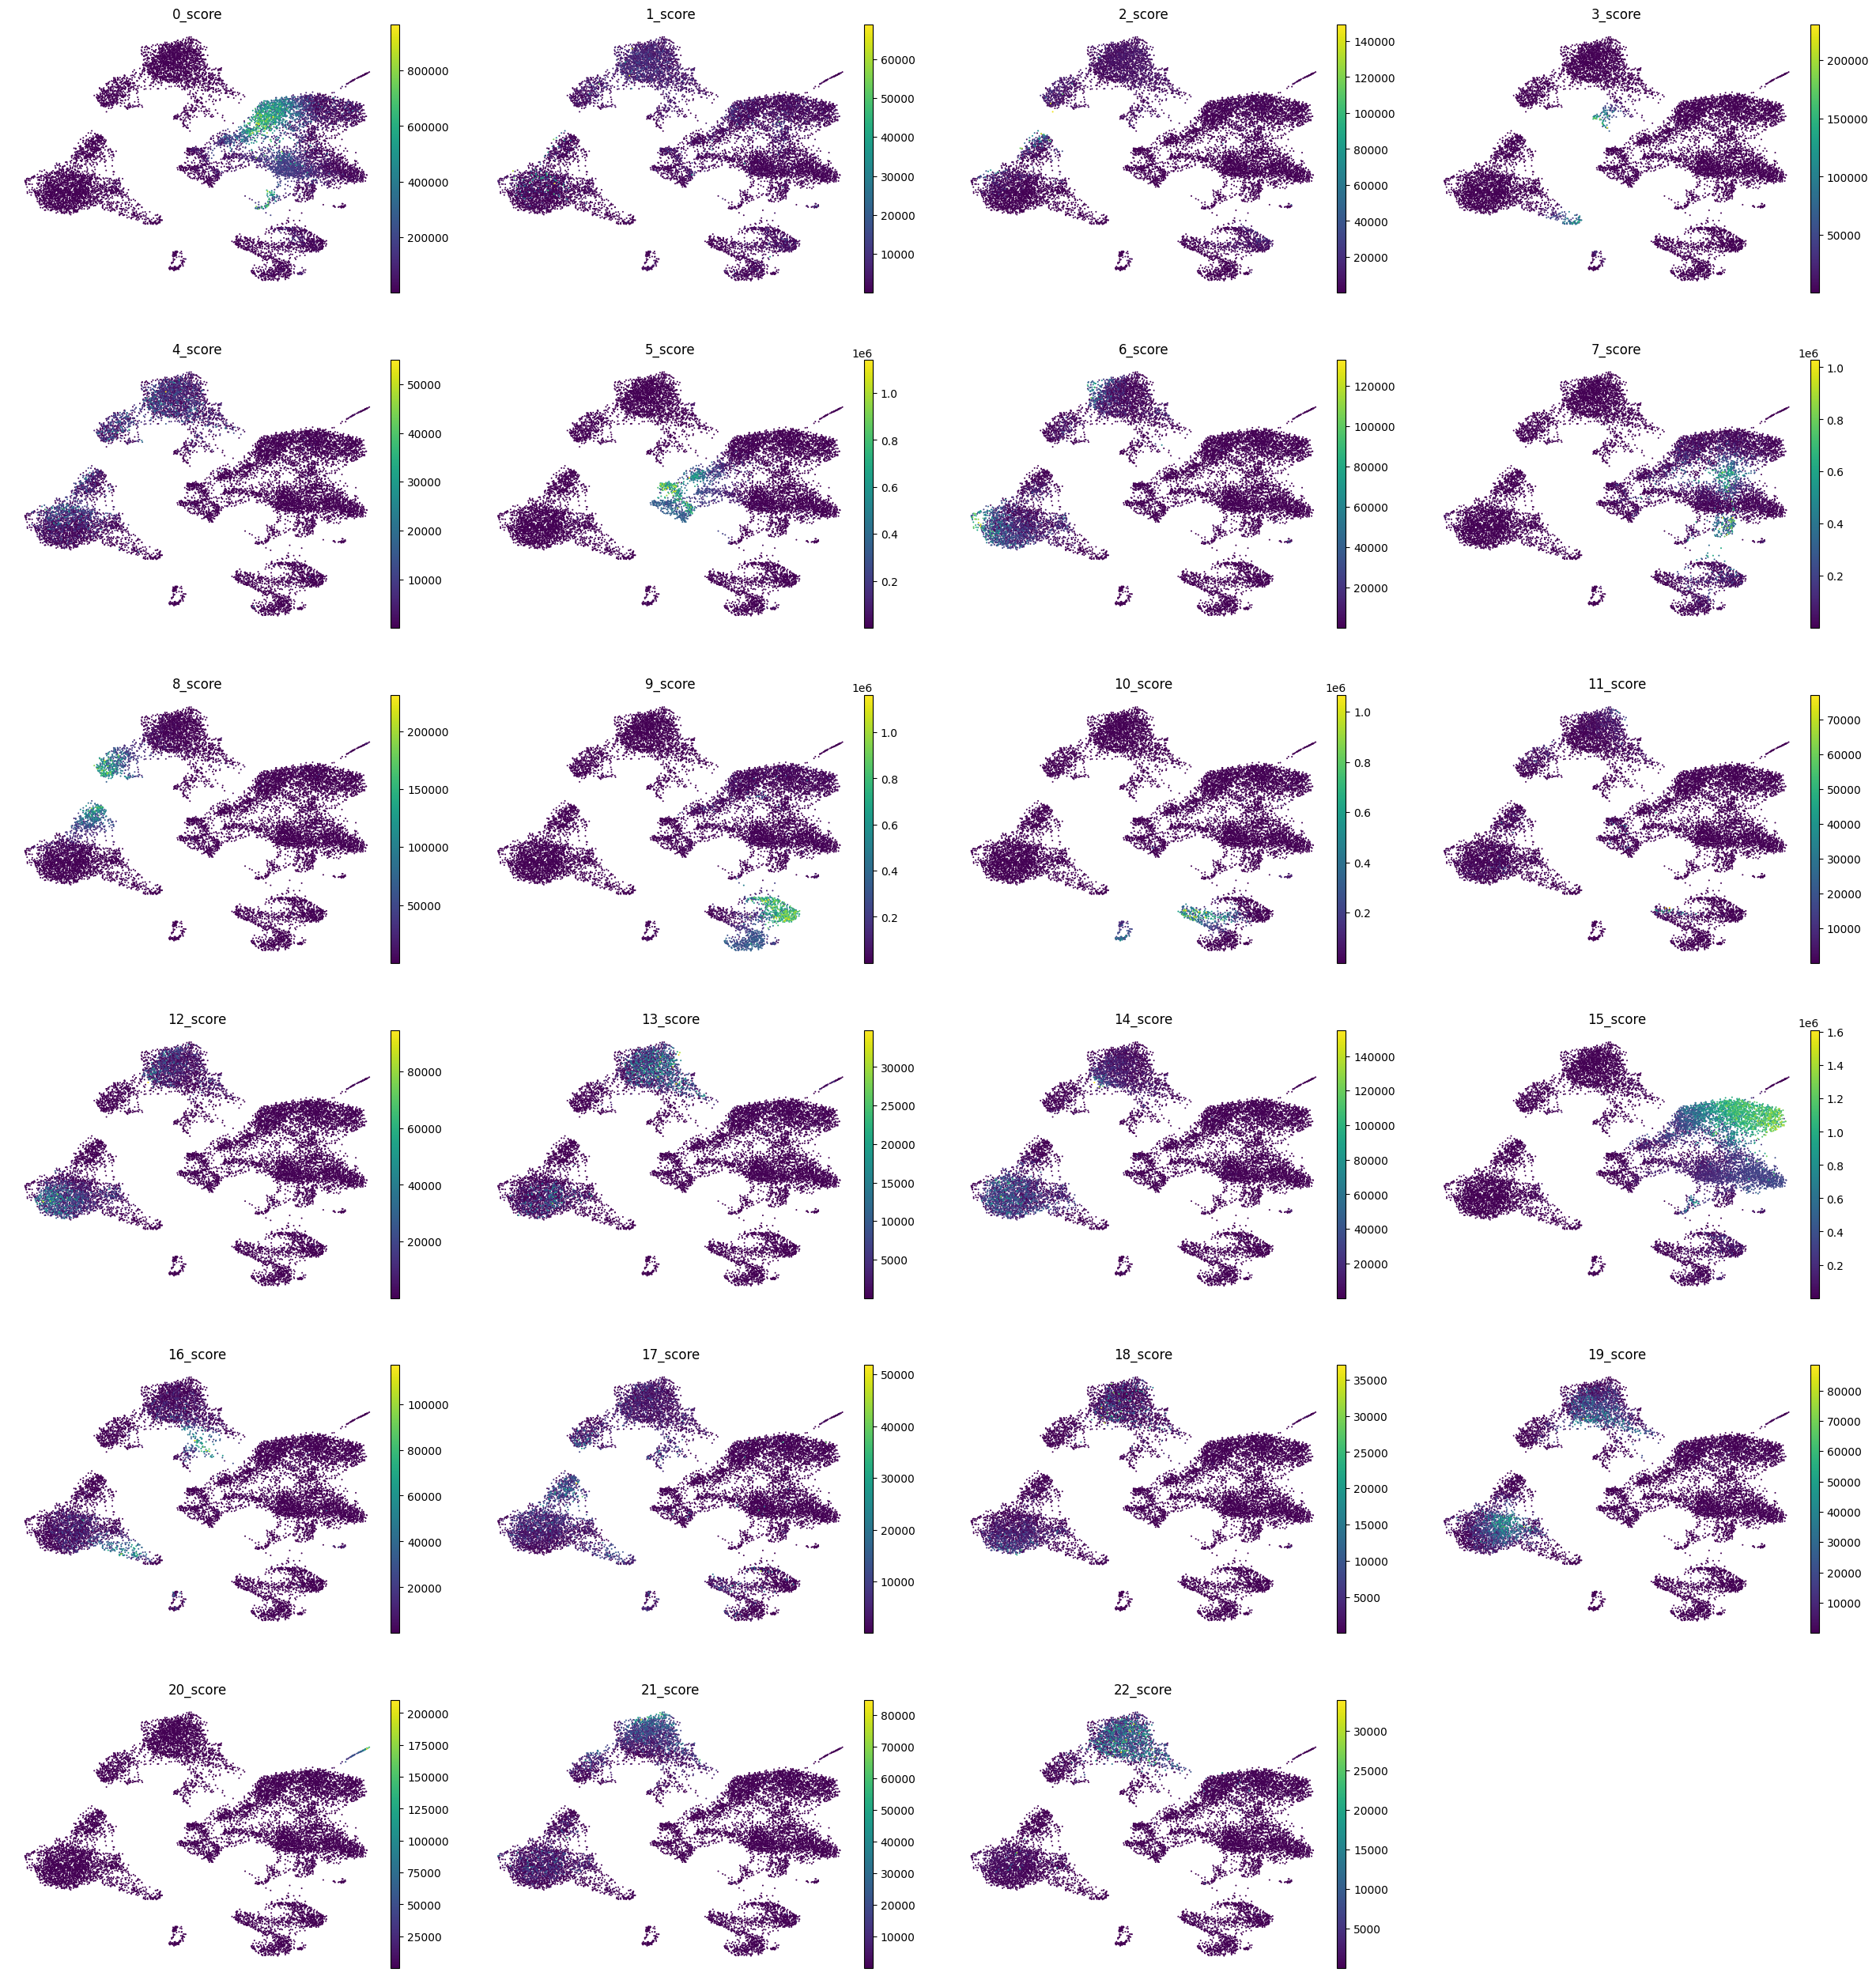

In [12]:
sc.pl.umap(scd.adata, color=[f'{i}_score' for i in range(len(scd.factor_lists[0]))], frameon=False)

/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


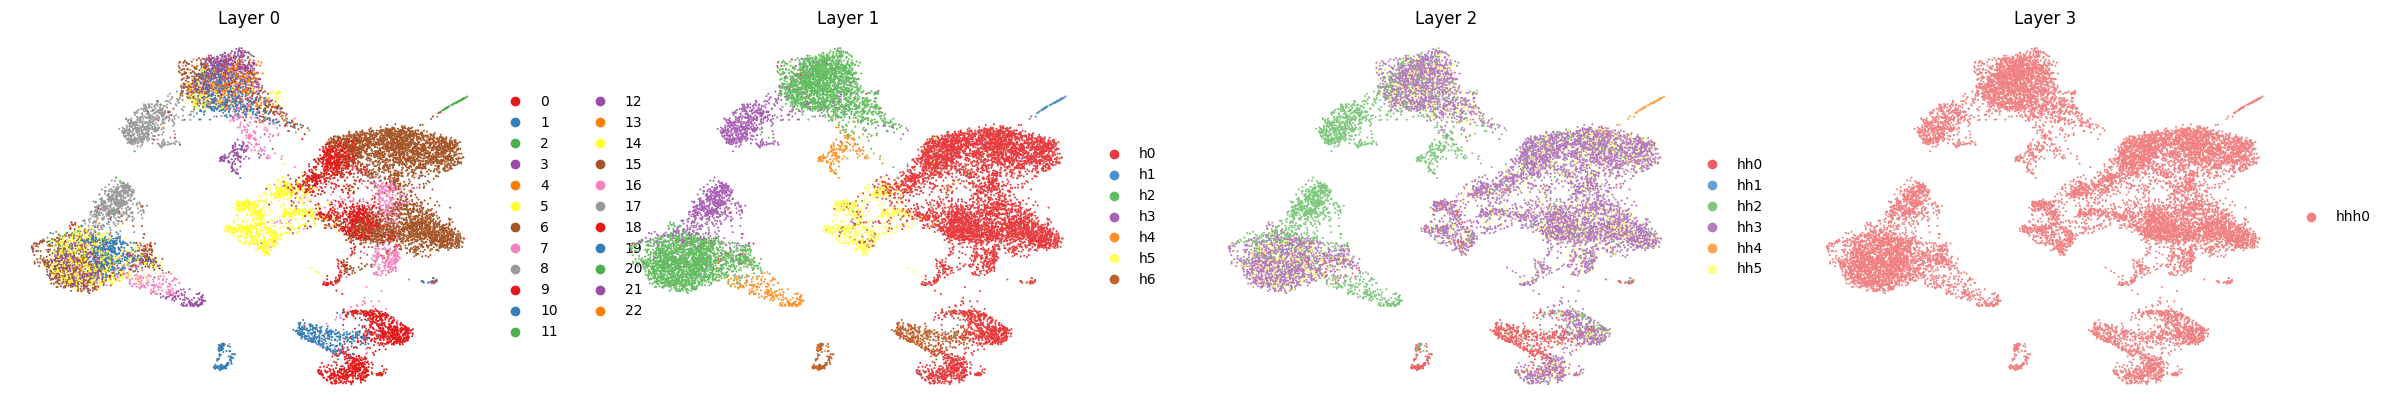

In [13]:
sc.pl.umap(scd.adata, color=['factor', 'hfactor', 'hhfactor', 'hhhfactor'], 
           title=['Layer 0', 'Layer 1', 'Layer 2', 'Layer 3'], frameon=False)

/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/pytho

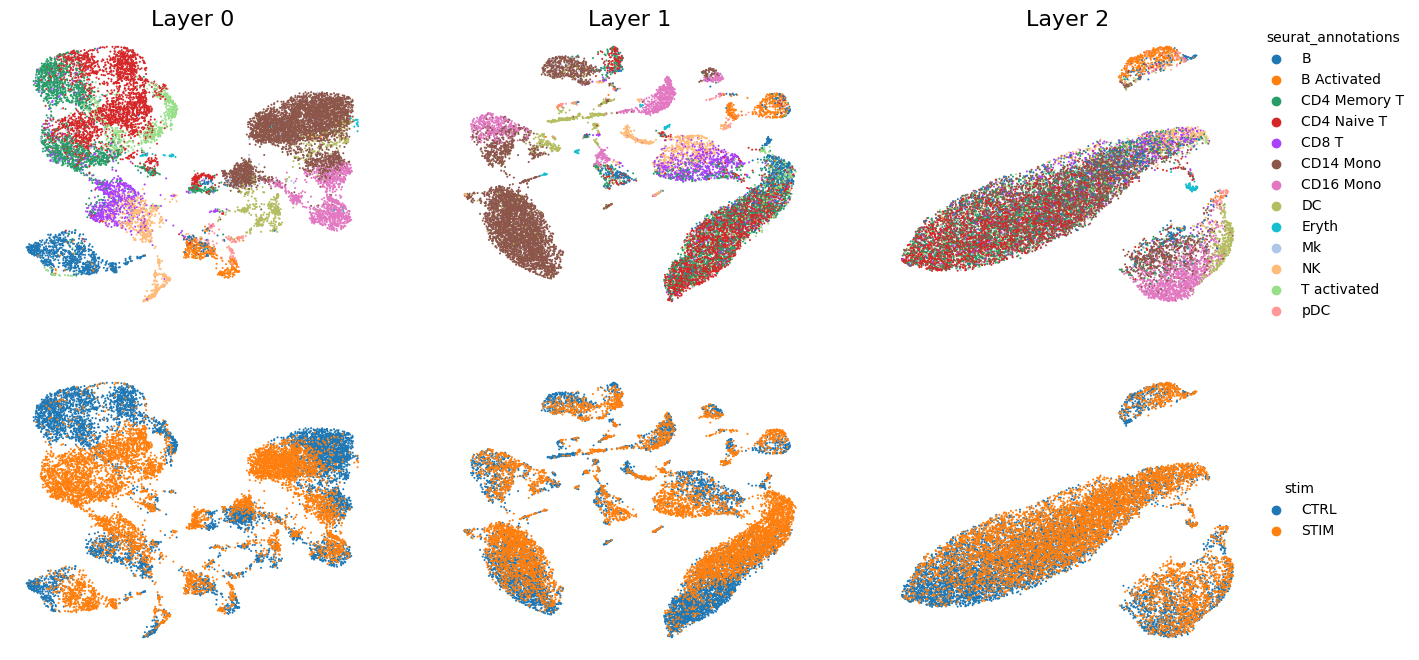

In [14]:
scd.plot_umaps(color=['seurat_annotations', 'stim'], figsize=(16,8), fontsize=16, show=True)

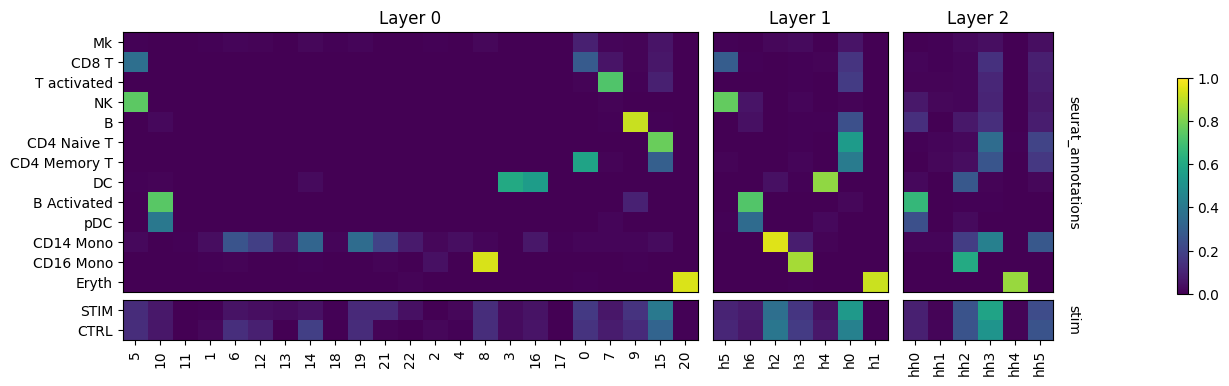

In [15]:
obs_keys = ['seurat_annotations', 'stim']
scd.plot_obs_scores(obs_keys, figsize=(16,4))

We can visualize the relationships between the different layers using `scd.make_graph`, which uses Graphviz to plot the scDEF graph.

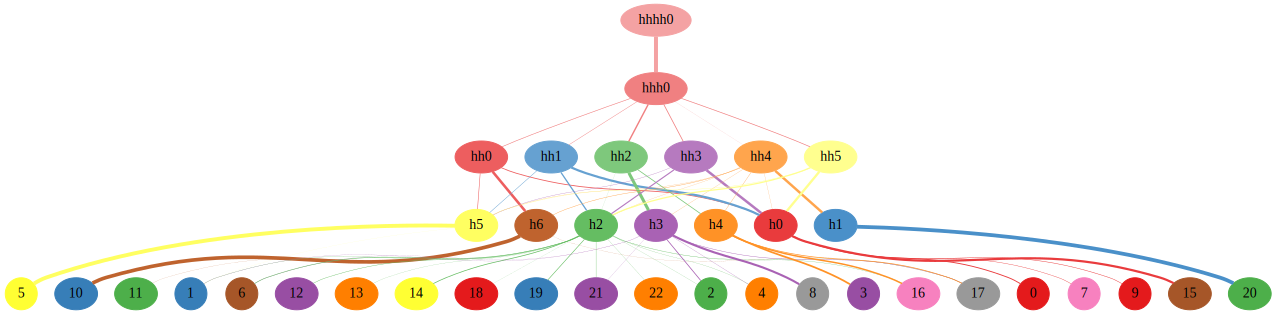

In [16]:
scd.make_graph(filled='factor', show_signatures=False) # simple graph with color-filled nodes
scd.graph # Graphviz object

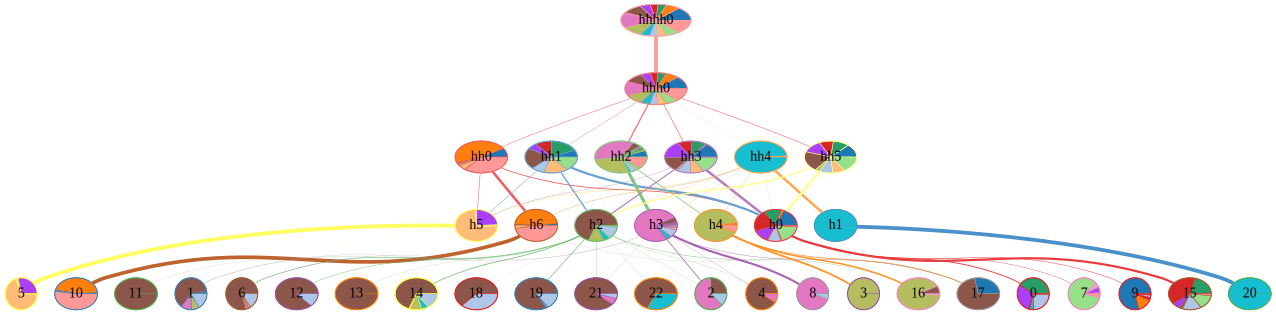

In [17]:
scd.make_graph(wedged='seurat_annotations', show_signatures=False) # graph with nodes filled by fraction of cells from each batch
scd.graph # Graphviz object

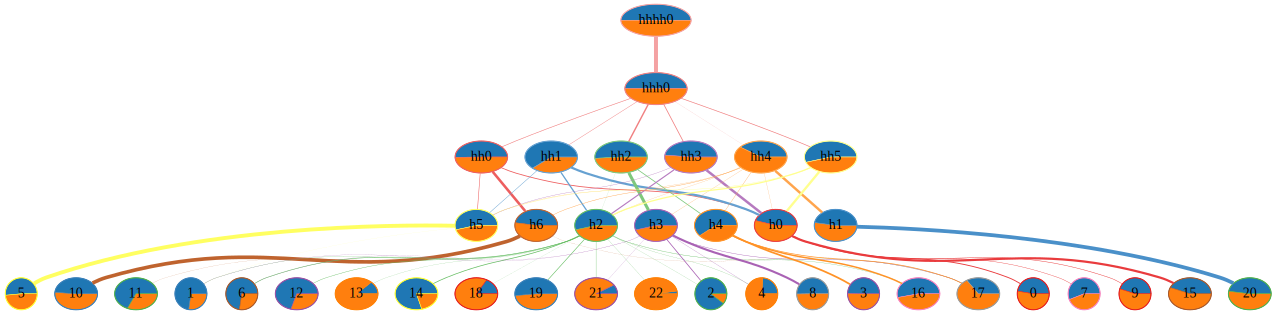

In [18]:
scd.make_graph(wedged='stim', show_signatures=False) # graph with nodes filled by fraction of cells from each batch
scd.graph # Graphviz object

This graph shows that both experiments are well represented in each factor at all levels, except for factor X which seems to be over-represented for cells in Experiment 1. Indeed, the cell type annotations indicate that Megakaryocytes only occur in Experiment 1.

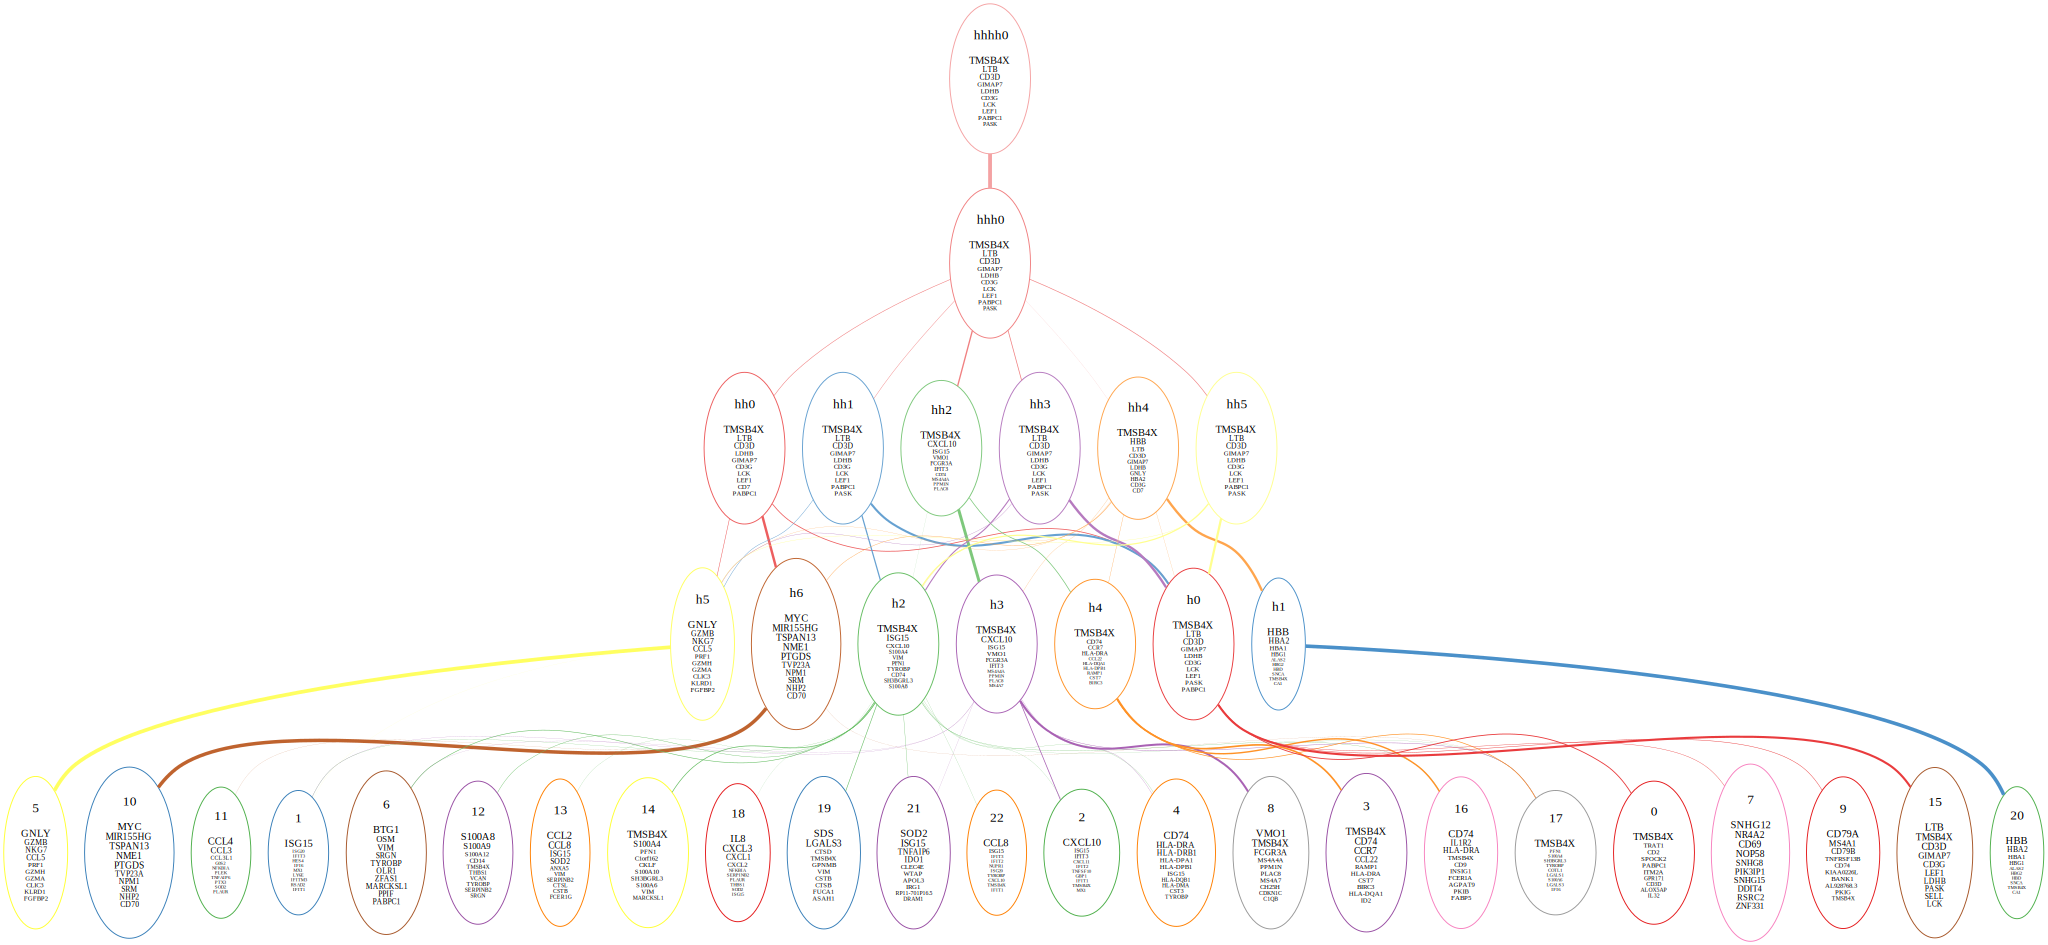

In [19]:
scd.make_graph(show_signatures=True) # simple graph with gene signatures in nodes
scd.graph

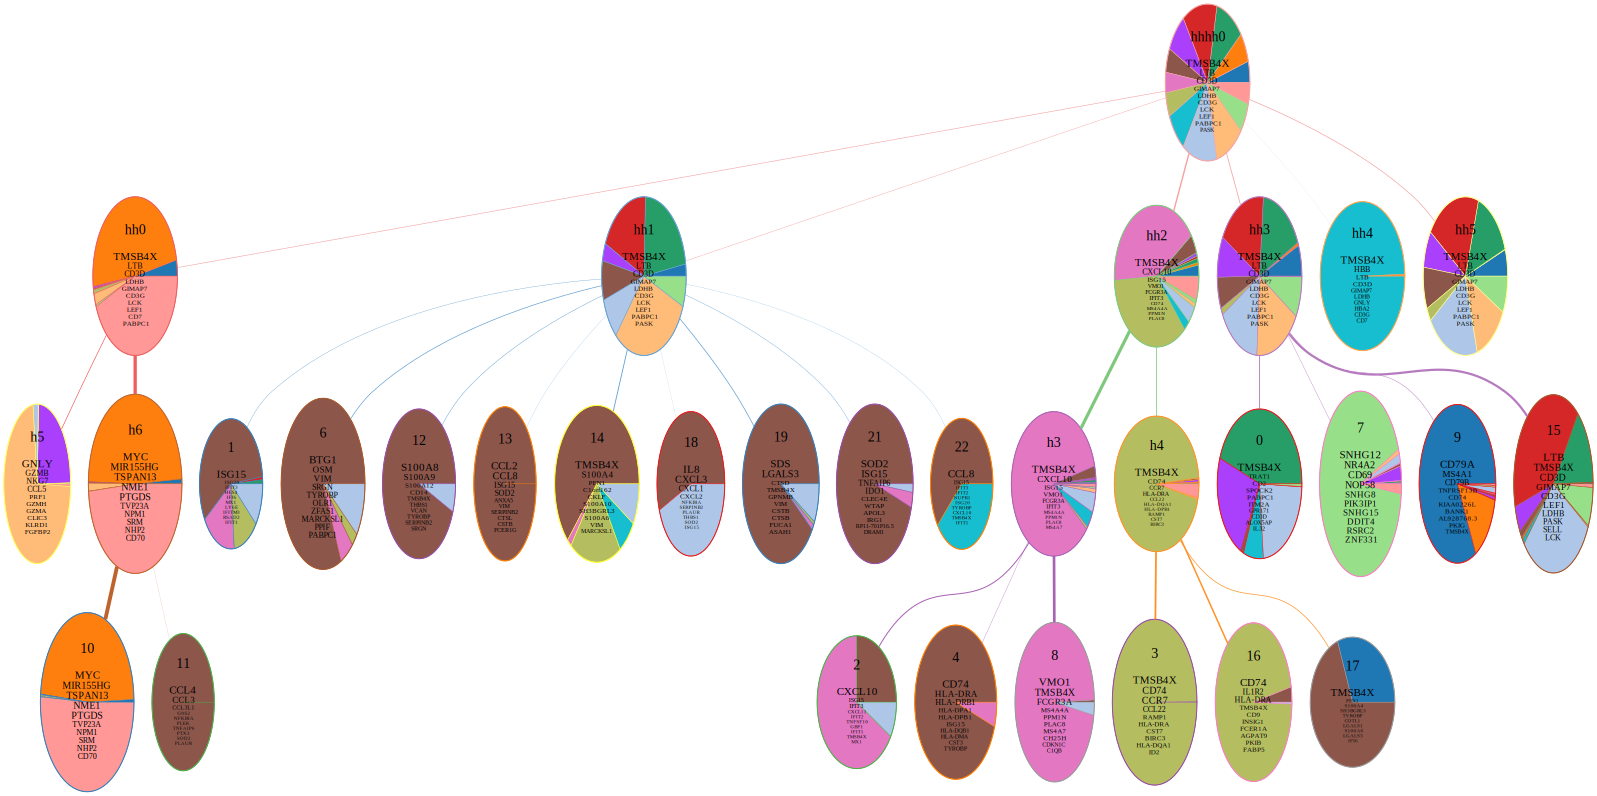

In [20]:
hierarchy_scdef = scd.get_hierarchy()
scd.make_graph(hierarchy=hierarchy_scdef, show_signatures=True, wedged='Cell types')
scd.graph

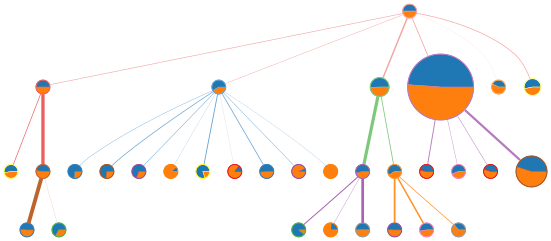

In [21]:
scd.make_graph(hierarchy=hierarchy_scdef, show_signatures=False, wedged='stim', 
               n_cells=True, show_label=False, node_size_max=1.5, node_size_min=.2) # scale by number of cells and remove labels
scd.graph

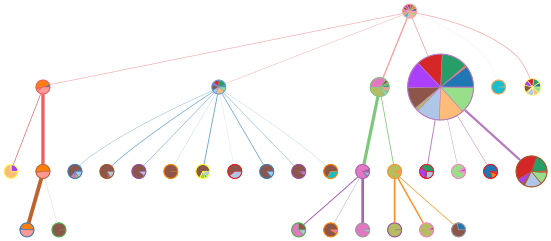

In [22]:
scd.make_graph(hierarchy=hierarchy_scdef, show_signatures=False, wedged='seurat_annotations', 
               n_cells=True, show_label=False, node_size_max=1.5, node_size_min=.2) # scale by number of cells and remove labels
scd.graph

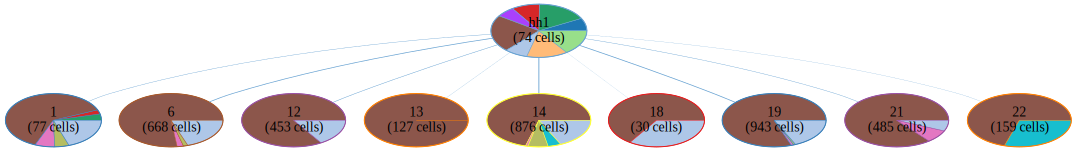

In [23]:
scd.make_graph(hierarchy=hierarchy_scdef, top_factor='hh1', show_signatures=False, wedged='seurat_annotations', 
               n_cells_label=True, show_label=True) # scale by number of cells and remove labels
scd.graph

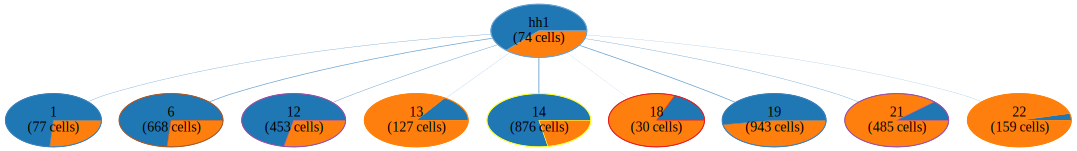

In [24]:
scd.make_graph(hierarchy=hierarchy_scdef, top_factor='hh1', show_signatures=False, wedged='stim', 
               n_cells_label=True, show_label=True) # scale by number of cells and remove labels
scd.graph

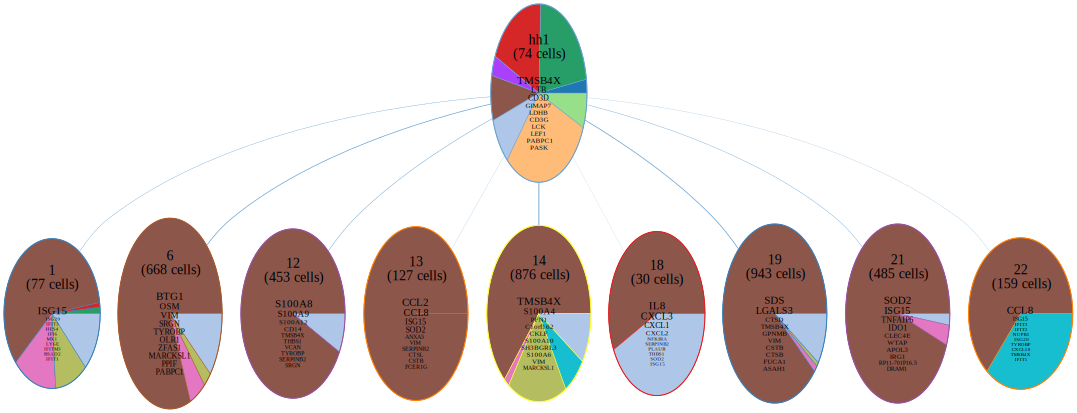

In [25]:
scd.make_graph(hierarchy=hierarchy_scdef, top_factor='hh1', show_signatures=True, wedged='seurat_annotations', 
               n_cells_label=True, show_label=True) # scale by number of cells and remove labels
scd.graph

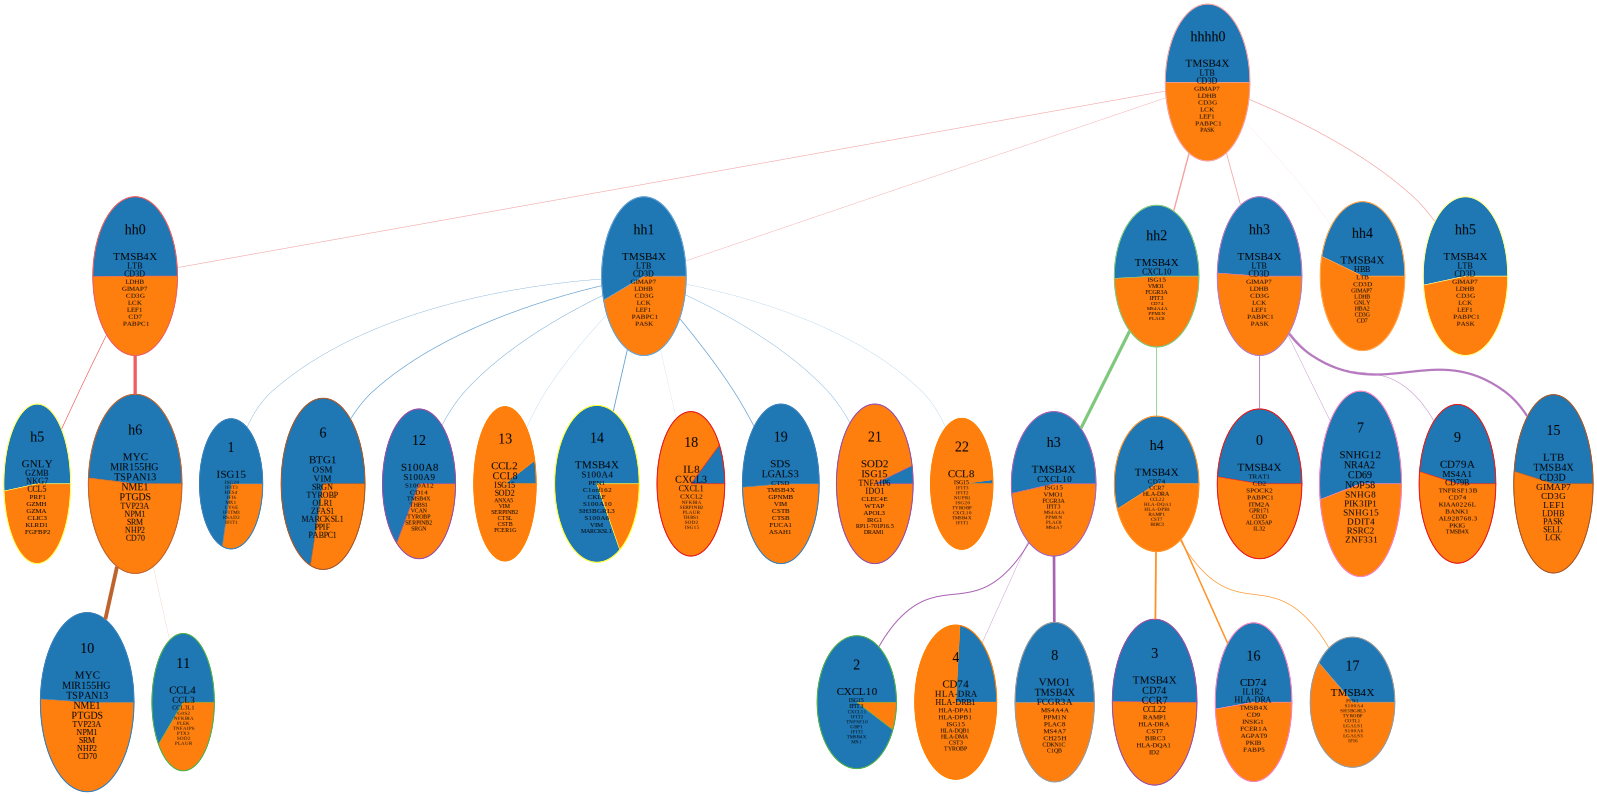

In [26]:
scd.make_graph(hierarchy=hierarchy_scdef, show_signatures=True, wedged='stim')
scd.graph

Finally, scDEF also comes with a utility function to plot associations between cell annotations and factors, using a dotplot. In this two-batch setting, this is useful to check which factors are batch-specific. 

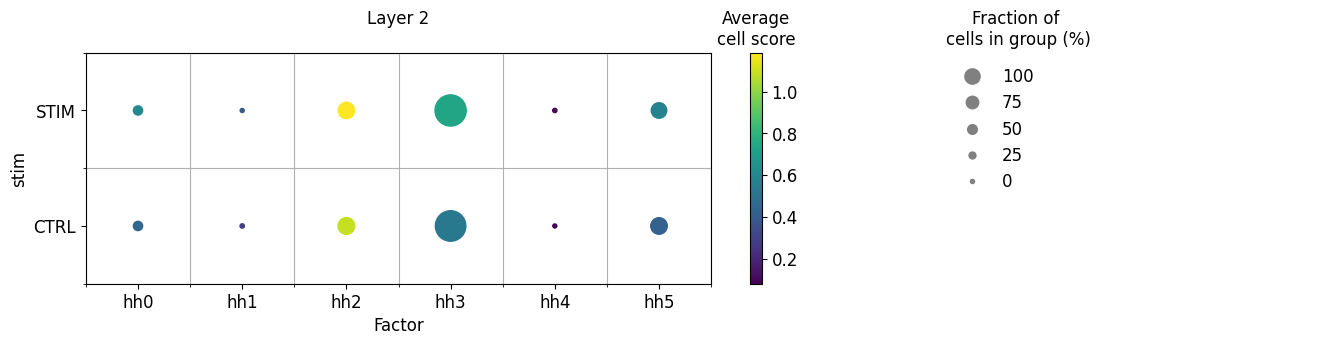

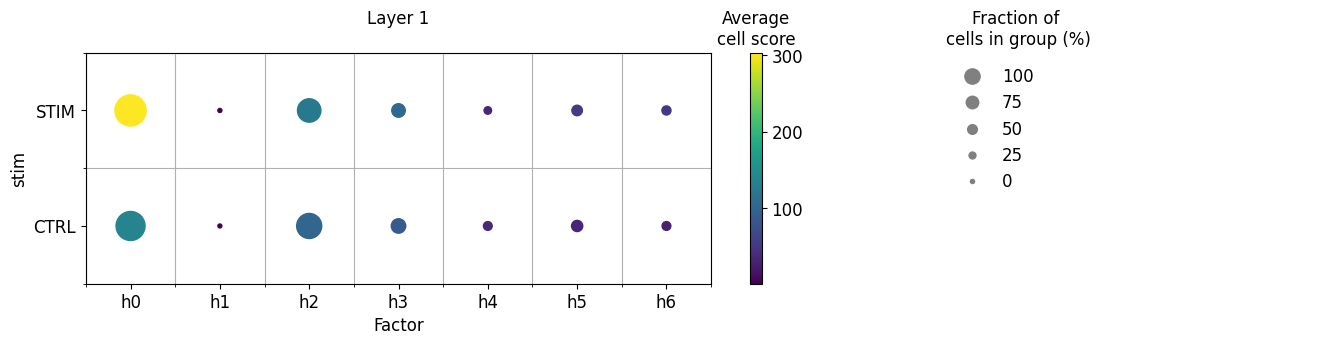

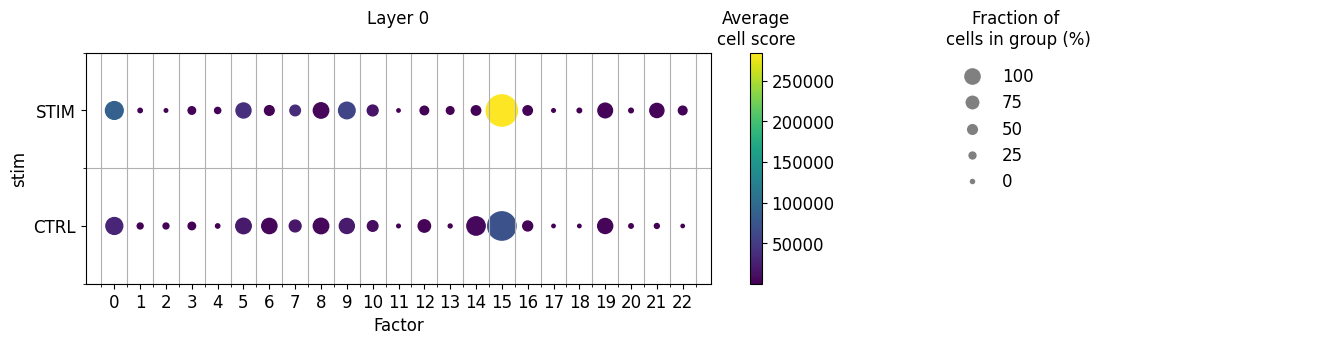

In [27]:
# Compare with batch annotations
scd.plot_obs_factor_dotplot('stim', 2, figsize=(16,3)) # Layer 2
scd.plot_obs_factor_dotplot('stim', 1, figsize=(16,3)) # Layer 1
scd.plot_obs_factor_dotplot('stim', 0, figsize=(16,3)) # Layer 0

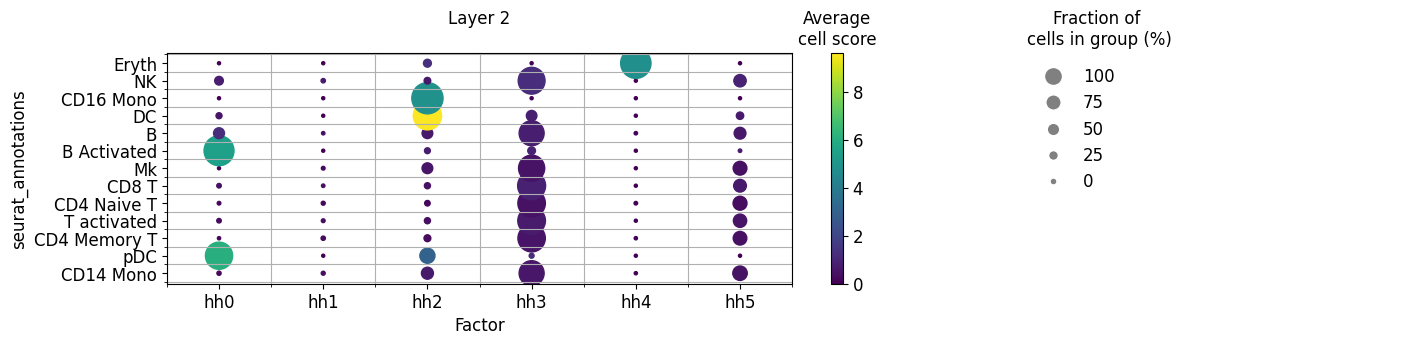

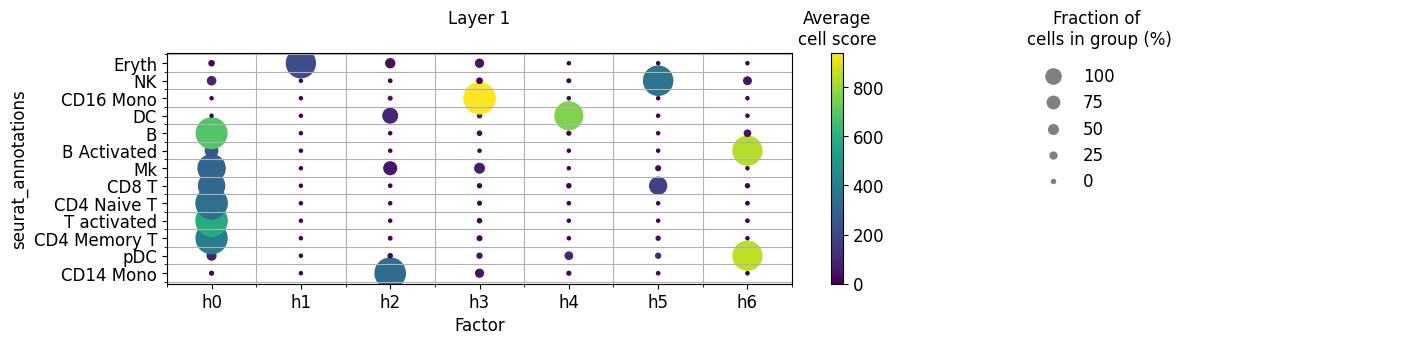

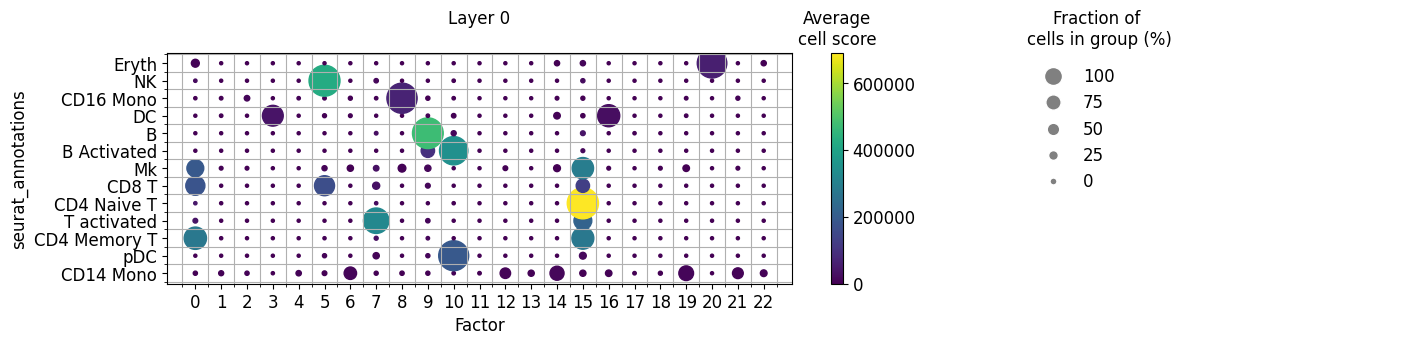

In [28]:
# Compare with batch annotations
scd.plot_obs_factor_dotplot('seurat_annotations', 2, figsize=(16,3)) # Layer 2
scd.plot_obs_factor_dotplot('seurat_annotations', 1, figsize=(16,3)) # Layer 1
scd.plot_obs_factor_dotplot('seurat_annotations', 0, figsize=(16,3)) # Layer 0